# Árboles de decisión y estimación de la componente estacional del recaudo de impuestos internos por la DIAN.

En primer lugar para poder realizar el modelo predictivo con arboles de decisión utilizando phyton, nos basaremos en lo encontrado en el análisis descriptivo aplicado utilizando R, y de este modo se realizará la eliminacion de la tendencia, por medio de un ajuste deterministico de una recta, luego procederemos  a realizar la estimación de la componente estacional utilizando series de fourier para posteriormente aplicar el modelo de Árboles de decisión. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression  # solo uso esta en la reg lineal
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import statsmodels.api as sm
import scipy as sp
import scipy.stats
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import STL
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
import numpy as np
import sklearn


## Carga de los datos. 

In [2]:
nombre_del_archivo = "dian_phyton.csv"
df = pd.read_csv(nombre_del_archivo,decimal=",")
dian = df.iloc[:, 1:]
dian["Impuestos"]=pd.to_numeric(dian["Impuestos"])
print(dian)

        Impuestos       fecha
0    1.512329e+06  2000-01-01
1    1.100415e+06  2000-02-01
2    1.228774e+06  2000-03-01
3    1.343029e+06  2000-04-01
4    1.293771e+06  2000-05-01
..            ...         ...
277  1.128225e+07  2023-02-01
278  1.611574e+07  2023-03-01
279  2.789091e+07  2023-04-01
280  2.216499e+07  2023-05-01
281  2.337360e+07  2023-06-01

[282 rows x 2 columns]


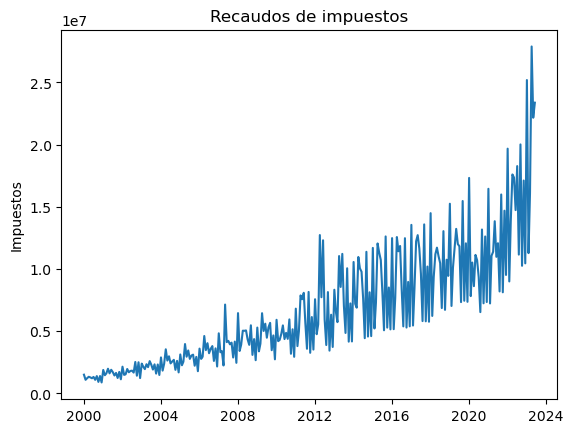

In [3]:
dian['fecha']=pd.to_datetime(dian['fecha']) # pasar a formato fecha
Valores_dian=dian.set_index('fecha') # nuevo dataframe indexado por la fecha
Valores_dian['Impuestos'] = pd.to_numeric(Valores_dian['Impuestos'], errors='coerce')
dian_ts=Valores_dian['Impuestos'] # vector con los valores de la serie

plt.plot(dian_ts)
plt.title('Recaudos de impuestos')
plt.ylabel('Impuestos')
plt.show()

Teniendo en cuenta lo elaborado en la parte descriptiva de R, podemos evidenciar que la serie presenta tendencia y tiene presencia de ciclos estacionales con periodo anual (es decir que $s=12$), por lo tanto no nos detendremos demasiado en el análisis de esto sino que en primer lugar ajustaremos la varianza teniendo en cuenta que el valor óptimo obtenido en el código de R, por esta razon los datos serán transformados utilizando el logaritmo, luego utilizando la estimación lineal deterministica eliminaremos la varianza y por ultimo vamos a realizar la estimación del ciclo estacional.

## Ajuste de la variabilidad utilizando la transformación box cox.


Nótese que en el código elaborado en R se obtiene un valor óptimo para $\lambda=0.1$, pero como este es cercano a 0, tomaremos el logaritmo de los datos.

In [4]:
Valores_dian.index.freq='MS'
dian_ts.index.freq='MS'#ts.index
sp.stats.boxcox(dian['Impuestos'],alpha=0.05)

(array([35.52496223, 33.95222601, 34.49152152, 34.93106955, 34.74579804,
        34.4718609 , 34.89183865, 33.94439976, 35.13789306, 33.15580725,
        35.15771393, 32.91021848, 36.67136016, 35.37905749, 35.86602767,
        36.92998987, 35.87277114, 36.70557681, 36.18113899, 35.30923856,
        35.97503468, 34.56556822, 36.2224835 , 34.12251889, 37.34328057,
        35.46558058, 35.61426616, 36.8753144 , 36.13208598, 36.4463067 ,
        36.51429367, 36.05892815, 38.19930131, 35.24510942, 38.15122899,
        34.53147955, 37.91738675, 37.30622855, 36.84773285, 37.80471102,
        37.25894192, 38.3435087 , 37.72800988, 36.7530649 , 37.78475651,
        35.8017055 , 37.75691468, 35.44769279, 38.92548146, 36.51840941,
        37.88823128, 40.03992611, 38.43542554, 39.09536491, 37.95582764,
        38.28414557, 38.55239518, 36.69590365, 38.38350308, 36.10637676,
        39.35519766, 37.61915598, 38.24177309, 40.66760851, 39.03275093,
        39.8956531 , 38.70392408, 39.20506679, 39.3

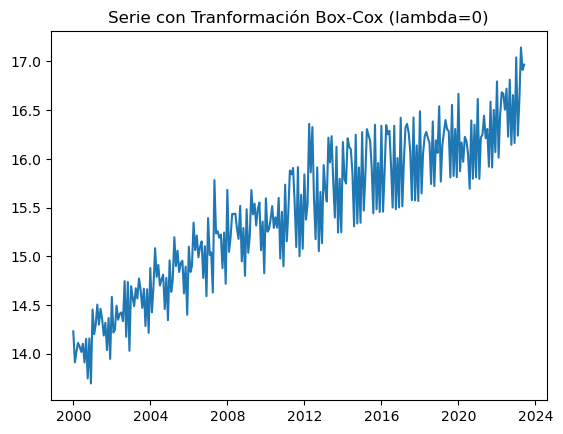

In [5]:
rdian=sp.stats.boxcox(dian['Impuestos'],lmbda=0)
dian = dian.assign(rdian=rdian) # al dataframe original le añadimos los valores de la transformación

rValordian=dian.set_index('fecha')  # Otro dataframe con el índice de la fecha
rdian_Varest= rValordian['rdian'] # la serie de la transformación guardada en el dataframe anterior
plt.plot(rdian_Varest)
plt.title('Serie con Tranformación Box-Cox (lambda=0)')
plt.show()

## Estimación y eliminación de la tendencia 

In [6]:
X1=np.arange(2000,2023.5,1/12)
X=X1

print(X1.shape)
#print(X1)

(282,)


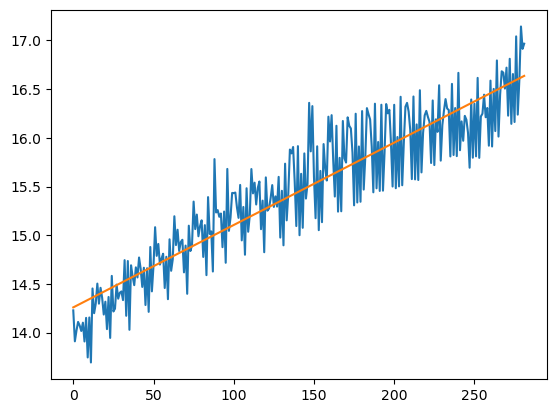

-188.74810617026472

In [7]:
from sklearn.linear_model import LinearRegression
X = np.reshape(X, (len(X), 1))
y =rdian_Varest.values
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)
plt.plot(y)
plt.plot(trend)
plt.show()
model.coef_
model.intercept_


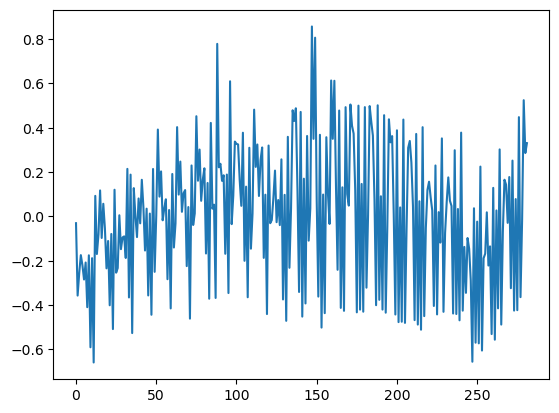

                   0
fecha               
2000-01-01 -0.030551
2000-02-01 -0.356973
2000-03-01 -0.255102
2000-04-01 -0.174650
2000-05-01 -0.220475
...              ...
2023-02-01 -0.364019
2023-03-01 -0.015912
2023-04-01  0.524134
2023-05-01  0.285888
2023-06-01  0.330523

[282 rows x 1 columns]


In [8]:
dian_sin_tend = [y[i]-trend[i] for i in range(0, len(dian_ts))]
# plot detrended
plt.plot(dian_sin_tend)
plt.show()
dian_detrend=pd.DataFrame(dian_sin_tend,index=dian_ts.index)
print(dian_detrend)


## Estimación y o eliminación de la componente estacional.


Ahora procederemos a estimar el ciclo estacional que se observa en esta serie de tiempo, es importante resaltar que con ayuda de los graficos exploratorios y el periodograma se observo que el periodo de la componente estacional es $s=12$, por lo tanto utilizaremos en primer lugar componentes de fourier, esto teniendo en cuenta que se aprecia que la componente estacional sigue un comportamiento deterministico y posiblemente sinosoidal.
Teniendo lo anterior en cuenta el modelo viene dado por:
$$\begin{align*}
x_t&=  ∑_{i=1}^k a_icos(k𝜔t)+b_isen(k𝜔t) + w_t \\
\end{align*}$$
Donde $k$ corresponderá al orden de la expansión en series de Fourier y los coeficientes $a_i$ y $b_i$ con $i=1,...,k$ serán estimados a través del método de mínimos cuadrados. El cálculo de esta componente se muestra a continuación considerando un orden $k=3$. 

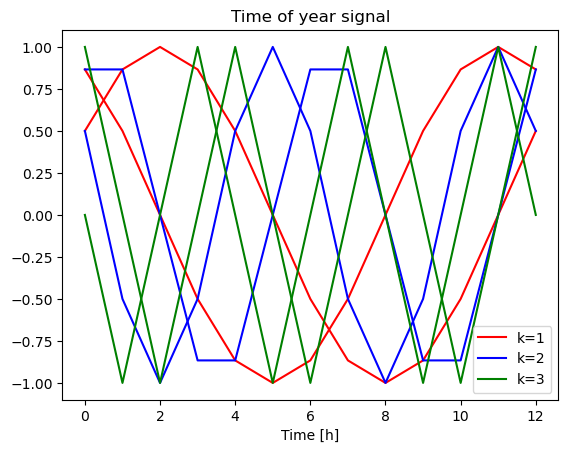

In [9]:
year = 1/(1/12)
dian2 = pd.DataFrame(dian_sin_tend)
#Fourier n=1 2pi*1
dian2['Year sin'] = np.sin(np.arange(1,283)*(2 * np.pi / year))
dian2['Year cos'] = np.cos(np.arange(1,283)*(2 * np.pi / year))

# Fourier n=2 2pi*2
dian2['Year sin2'] = np.sin(np.arange(1,283)*(4 * np.pi / year))
dian2['Year cos2'] = np.cos(np.arange(1,283)*(4 * np.pi / year))

# Fourier n=3 2pi*3
dian2['Year sin3'] = np.sin(np.arange(1,283)*(6 * np.pi / year))
dian2['Year cos3'] = np.cos(np.arange(1,283)*(6 * np.pi / year))

plt.plot(np.array(dian2['Year sin'])[:13], color="red", label="k=1")
plt.plot(np.array(dian2['Year cos'])[:13], color="red")

plt.plot(np.array(dian2['Year sin2'])[:13], color="blue", label="k=2")
plt.plot(np.array(dian2['Year cos2'])[:13], color="blue")

plt.plot(np.array(dian2['Year sin3'])[:13], color="green", label="k=3")
plt.plot(np.array(dian2['Year cos3'])[:13], color="green")

plt.xlabel('Time [h]')
plt.title('Time of year signal')
plt.legend()

In [10]:
X=np.column_stack((dian2['Year cos'],dian2['Year sin'],dian2['Year cos2'],dian2['Year sin2'],dian2['Year cos3'],dian2['Year sin3']))
linmodel_ciclo = sm.OLS(dian_sin_tend, X)
results_ciclo = linmodel_ciclo.fit()
print(results_ciclo.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.207
Model:                            OLS   Adj. R-squared (uncentered):              0.190
Method:                 Least Squares   F-statistic:                              12.02
Date:                Wed, 04 Oct 2023   Prob (F-statistic):                    5.39e-12
Time:                        18:19:52   Log-Likelihood:                         -39.148
No. Observations:                 282   AIC:                                      90.30
Df Residuals:                     276   BIC:                                      112.1
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

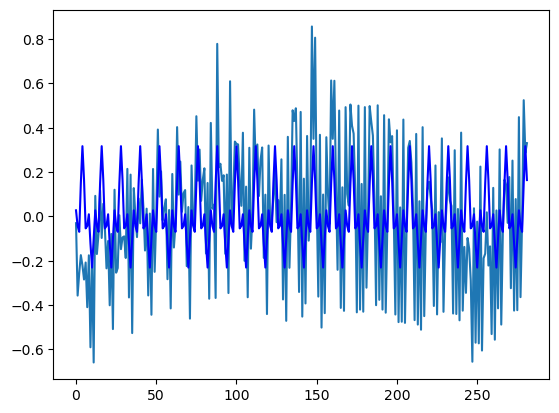

In [11]:
ypred = results_ciclo.predict(X)
dian2["predict estacion"] = ypred
plt.plot(dian_sin_tend)
plt.plot(dian2["predict estacion"], color="blue")
plt.show()

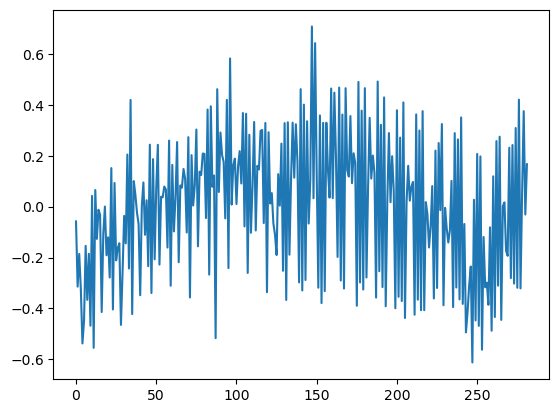

In [12]:
dian_sin_tend_sin_esta=dian_sin_tend-ypred
plt.plot(dian_sin_tend_sin_esta)

## Árboles de decisión.


### Arboles de decisión con los datos solo quitando la tendencia.

 Para realizar el modelamiento de los arboles de decisión para esta serie de tiempo, vamos a proceder a realizar el ajuste del modelo utilizando los datos sin tendencia pero con componente estacional , como los datos a los cuales se les eliminó la componente estacional y la tendencia, posteriormente realizaremos la suma de dichas estimaciones para volver a los datos reales.

In [13]:
#Creación de variables rezagadas.
from pandas import DataFrame
dian3=pd.DataFrame(dian_sin_tend)
# reframe as supervised learning
# lag observation (t-1) is the input variable and t is the output variable.
df1 = DataFrame()
print(df1)

for i in range(12,0,-1):# Colocar retardo de tamaño 12 
    df1[['t-'+str(i)]] = dian_detrend.shift(i)
    
print(df1)

Empty DataFrame
Columns: []
Index: []
                t-12      t-11      t-10       t-9       t-8       t-7  \
fecha                                                                    
2000-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2000-02-01       NaN       NaN       NaN       NaN       NaN       NaN   
2000-03-01       NaN       NaN       NaN       NaN       NaN       NaN   
2000-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
2000-05-01       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2023-02-01 -0.487749 -0.067365  0.165620  0.143039 -0.029033  0.177592   
2023-03-01 -0.067365  0.165620  0.143039 -0.029033  0.177592 -0.323814   
2023-04-01  0.165620  0.143039 -0.029033  0.177592 -0.323814  0.251697   
2023-05-01  0.143039 -0.029033  0.177592 -0.323814  0.251697 -0.424761   
2023-06-01 -0.029033  0.177592 -0.323814  0.251697 -0.424761  0.078179   


In [14]:
df1['t'] = dian_detrend.values
print(df1.head(13))

                t-12      t-11      t-10       t-9       t-8       t-7  \
fecha                                                                    
2000-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2000-02-01       NaN       NaN       NaN       NaN       NaN       NaN   
2000-03-01       NaN       NaN       NaN       NaN       NaN       NaN   
2000-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
2000-05-01       NaN       NaN       NaN       NaN       NaN       NaN   
2000-06-01       NaN       NaN       NaN       NaN       NaN       NaN   
2000-07-01       NaN       NaN       NaN       NaN       NaN       NaN   
2000-08-01       NaN       NaN       NaN       NaN       NaN -0.030551   
2000-09-01       NaN       NaN       NaN       NaN -0.030551 -0.356973   
2000-10-01       NaN       NaN       NaN -0.030551 -0.356973 -0.255102   
2000-11-01       NaN       NaN -0.030551 -0.356973 -0.255102 -0.174650   
2000-12-01       NaN -0.030551 -0.3569

In [15]:
df1_dian = df1[12:]
print(df1_dian)
df1_dian.size

                t-12      t-11      t-10       t-9       t-8       t-7  \
fecha                                                                    
2001-01-01 -0.030551 -0.356973 -0.255102 -0.174650 -0.220475 -0.284476   
2001-02-01 -0.356973 -0.255102 -0.174650 -0.220475 -0.284476 -0.207925   
2001-03-01 -0.255102 -0.174650 -0.220475 -0.284476 -0.207925 -0.409336   
2001-04-01 -0.174650 -0.220475 -0.284476 -0.207925 -0.409336 -0.175416   
2001-05-01 -0.220475 -0.284476 -0.207925 -0.409336 -0.175416 -0.590146   
...              ...       ...       ...       ...       ...       ...   
2023-02-01 -0.487749 -0.067365  0.165620  0.143039 -0.029033  0.177592   
2023-03-01 -0.067365  0.165620  0.143039 -0.029033  0.177592 -0.323814   
2023-04-01  0.165620  0.143039 -0.029033  0.177592 -0.323814  0.251697   
2023-05-01  0.143039 -0.029033  0.177592 -0.323814  0.251697 -0.424761   
2023-06-01 -0.029033  0.177592 -0.323814  0.251697 -0.424761  0.078179   

                 t-6       t-5       

3510

In [16]:
diansplit = df1_dian.values
# split into lagged variables and original time series
X1= diansplit[:, 0:-1]  # slice all rows and start with column 0 and go up to but not including the last column
y1 =diansplit[:,-1]  # slice all rows and last column, essentially separating out 't' column
print(X1)
print(y1)

[[-0.03055093 -0.35697273 -0.25510204 ... -0.59014553 -0.18836349
  -0.65873279]
 [-0.35697273 -0.25510204 -0.17464959 ... -0.18836349 -0.65873279
   0.09268444]
 [-0.25510204 -0.17464959 -0.22047525 ... -0.65873279  0.09268444
  -0.16953268]
 ...
 [ 0.16561959  0.14303852 -0.02903292 ...  0.44774806 -0.36401943
  -0.01591199]
 [ 0.14303852 -0.02903292  0.17759223 ... -0.36401943 -0.01591199
   0.52413354]
 [-0.02903292  0.17759223 -0.3238138  ... -0.01591199  0.52413354
   0.28588802]]
[ 0.09268444 -0.16953268 -0.08150814  0.11722645 -0.09709678  0.05701155
 -0.05346884 -0.23420493 -0.11080669 -0.40077547 -0.07921743 -0.50807499
  0.1202845  -0.25381636 -0.23276139  0.00519323 -0.14765874 -0.09478178
 -0.0900255  -0.18737661  0.21439618 -0.36543146  0.18847196 -0.52611793
  0.12760969  0.00325181 -0.09316841  0.08098047 -0.03115547  0.16523198
  0.04110747 -0.15373359  0.03491794 -0.35641024  0.01273884 -0.44346421
  0.21400631 -0.24994067  0.00369399  0.39178925  0.08933023  0.202986

In [17]:
# Target Train-Validation-Test split(70-10-20)
from pandas import read_csv

Y1 = y1
traintarget_size = int(len(Y1) * 0.70) 
valtarget_size = int(len(Y1) * 0.10)+1# Set split
testtarget_size = int(len(Y1) * 0.20)# Set split
train_target, val_target,test_target = Y1[0:traintarget_size],Y1[(traintarget_size):(traintarget_size+valtarget_size)] ,Y1[(traintarget_size+valtarget_size):len(Y1)]

print('Observaciones respuesta: %d' % (len(Y1)))
print('Tamaño respuestas de entrenamiento: %d' % (len(train_target)))
print('Tamaño respuestas de validación: %d' % (len(val_target)))
print('Tamaño respuestas de prueba: %d' % (len(test_target)))

trainfeature_size = int(len(X1) * 0.70)
valfeature_size = int(len(X1) * 0.10)+1# Set split
testfeature_size = int(len(X1) * 0.20)# Set split
train_feature, val_feature,test_feature = X1[0:traintarget_size],X1[(traintarget_size):(traintarget_size+valtarget_size)] ,X1[(traintarget_size+valtarget_size):len(Y1)]

print('Observaciones covariables: %d' % (len(X1)))
print('Tamaño covariables de entrenamiento: %d' % (len(train_feature)))
print('Tamaño covariables de validación: %d' % (len(val_feature)))
print('Tamaño covariables de prueba: %d' % (len(test_feature)))


Observaciones respuesta: 270
Tamaño respuestas de entrenamiento: 189
Tamaño respuestas de validación: 28
Tamaño respuestas de prueba: 53
Observaciones covariables: 270
Tamaño covariables de entrenamiento: 189
Tamaño covariables de validación: 28
Tamaño covariables de prueba: 53


In [18]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree_dian = DecisionTreeRegressor()  # max-depth not set
# The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
# Fit the model to the training features(covariables) and targets(respuestas)
decision_tree_dian.fit(train_feature, train_target)

# Check the score on train and test
print("Coeficiente R2 sobre el conjunto de entrenamiento:",decision_tree_dian.score(train_feature, train_target))
print("Coeficiente R2 sobre el conjunto de Validación:",decision_tree_dian.score(val_feature,val_target))  # predictions are horrible if negative value, no relationship if 0
print("el RECM sobre validación es:",(((decision_tree_dian.predict(val_feature)-val_target)**2).mean()) )


Coeficiente R2 sobre el conjunto de entrenamiento: 1.0
Coeficiente R2 sobre el conjunto de Validación: 0.8001922038339722
el RECM sobre validación es: 0.020877397481557643


In [19]:
# Find the best Max Depth

# Loop through a few different max depths and check the performance
# Try different max depths. We want to optimize our ML models to make the best predictions possible.
# For regular decision trees, max_depth, which is a hyperparameter, limits the number of splits in a tree.
# You can find the best value of max_depth based on the R-squared score of the model on the test set.


for d in [2, 3, 4, 5,6,7,8,9,10,11]:
    # Create the tree and fit it
    decision_tree_dian = DecisionTreeRegressor(max_depth=d)
    decision_tree_dian.fit(train_feature, train_target)

    # Print out the scores on train and test
    print('Produnidad=', str(d))
    print("Coeficiente R2 sobre el conjunto de entrenamiento:",decision_tree_dian.score(train_feature, train_target))
    print("Coeficiente R2 sobre el conjunto de validación:",decision_tree_dian.score(val_feature, val_target))  # You want the test score to be positive and high
    print("el RECM sobre el conjunto de validación es:",sklearn.metrics.mean_squared_error(decision_tree_dian.predict(val_feature),val_target, squared=False),"\n")

Produnidad= 2
Coeficiente R2 sobre el conjunto de entrenamiento: 0.6982464595759064
Coeficiente R2 sobre el conjunto de validación: 0.8877321692231351
el RECM sobre el conjunto de validación es: 0.10830777416251326 

Produnidad= 3
Coeficiente R2 sobre el conjunto de entrenamiento: 0.7602212026536559
Coeficiente R2 sobre el conjunto de validación: 0.8751224117272268
el RECM sobre el conjunto de validación es: 0.11422843228444957 

Produnidad= 4
Coeficiente R2 sobre el conjunto de entrenamiento: 0.826045599770773
Coeficiente R2 sobre el conjunto de validación: 0.7708157078645251
el RECM sobre el conjunto de validación es: 0.15474776644432967 

Produnidad= 5
Coeficiente R2 sobre el conjunto de entrenamiento: 0.8789319891483808
Coeficiente R2 sobre el conjunto de validación: 0.7524828146192706
el RECM sobre el conjunto de validación es: 0.16081799526873317 

Produnidad= 6
Coeficiente R2 sobre el conjunto de entrenamiento: 0.9142938556964194
Coeficiente R2 sobre el conjunto de validación: 0

Teniendo en cuenta la explroación anterior, es posible observar que aquella que hace maximo el valor $R^{2}$ y minimiza el error cuadratico medio (RECM) es el valor XXXXXX por lo  tanto se elige esta profundidad com ohiper parametro para continuar con la construcción del modelo. **(Por ahora voy a utilizar 4 de profundidad pero segun lo anterior es 2 de profundidad pero hay que preguntarle al profe a ver que dice)**

## Juntando entrenamiento y validación.


In [20]:
print(type(train_feature))
print(type(val_feature))

#######

print(type(train_target))
print(type(val_target))

####
print(train_feature.shape)
print(val_feature.shape)

#####

####
print(train_target.shape)
print(val_target.shape)

###Concatenate Validation and test

train_val_feature=np.concatenate((train_feature,val_feature),axis=0)
train_val_target=np.concatenate((train_target,val_target),axis=0)
print(train_val_feature.shape)
print(train_val_target.shape)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(189, 12)
(28, 12)
(189,)
(28,)
(217, 12)
(217,)


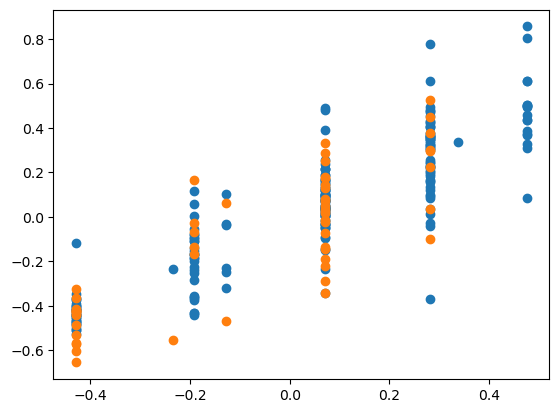

Raíz de la Pérdida cuadrática Entrenamiento: 0.14181786700257104
Raíz de la Pérdida cuadrática Prueba: 0.17666026756068792


In [51]:
# Prediccion utilizando los datos sumados de entrenamiento y validación y con la profundidad 4.

from matplotlib import pyplot as plt

# UUsando la mejor maxima profundidad

decision_tree_dian = DecisionTreeRegressor(max_depth=3)  # fill in best max depth here
decision_tree_dian.fit(train_val_feature, train_val_target)

# Prediciendo valores para entrenamiento y prueba 
train_val_prediction = decision_tree_dian.predict(train_val_feature)
test_prediction = decision_tree_dian.predict(test_feature)

# Comparación de los valores predichos vs los reales 
plt.scatter(train_val_prediction, train_val_target, label='train')  # blue
plt.scatter(test_prediction, test_target, label='test')  # orange
plt.show()
print("Raíz de la Pérdida cuadrática Entrenamiento:",sklearn.metrics.mean_squared_error( train_val_prediction, train_val_target,squared=False))

print("Raíz de la Pérdida cuadrática Prueba:",sklearn.metrics.mean_squared_error(test_prediction, test_target,squared=False))

In [22]:
from sklearn import tree

listacaract=list(df1_dian.columns.values)
respuesta=listacaract.pop()
text_representation = tree.export_text(decision_tree_dian)
print(text_representation)

|--- feature_0 <= -0.16
|   |--- feature_0 <= -0.37
|   |   |--- feature_4 <= -0.58
|   |   |   |--- value: [-0.23]
|   |   |--- feature_4 >  -0.58
|   |   |   |--- value: [-0.43]
|   |--- feature_0 >  -0.37
|   |   |--- feature_1 <= 0.69
|   |   |   |--- value: [-0.19]
|   |   |--- feature_1 >  0.69
|   |   |   |--- value: [0.34]
|--- feature_0 >  -0.16
|   |--- feature_0 <= 0.16
|   |   |--- feature_10 <= -0.43
|   |   |   |--- value: [-0.13]
|   |   |--- feature_10 >  -0.43
|   |   |   |--- value: [0.07]
|   |--- feature_0 >  0.16
|   |   |--- feature_0 <= 0.45
|   |   |   |--- value: [0.28]
|   |   |--- feature_0 >  0.45
|   |   |   |--- value: [0.48]



In [23]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree_dian, 
                   feature_names=listacaract,  
                   class_names=respuesta,
                   filled=True)

InvalidParameterError: The 'class_names' parameter of plot_tree must be an instance of 'list' or None. Got 't' instead.

<Figure size 2500x2000 with 0 Axes>

Ahora se van a observar los tamaños de los conjuntos usados para entrenamiento y pureba con el fin de realizar los graficos de la serie real con las predicciones.

In [26]:
print(train_val_prediction.size)
print(train_val_target.size)

print(test_prediction.size)
print(test_target.size)

217
217
53
53


In [30]:
indicetrian_val_test=df1_dian.index
print(indicetrian_val_test.size)  ###Tamaño del índice
indicetrain_val=indicetrian_val_test[0:217]
indicetest=indicetrian_val_test[217:270]

270


In [31]:
print(indicetrain_val.size)
print(indicetest.size)

217
53


In [33]:
targetjoint=np.concatenate((train_val_target,test_target))
predictionjoint=np.concatenate((train_val_prediction,test_prediction))
print(targetjoint.size)
print(predictionjoint.size)

270
270


In [34]:
d = {'observado': targetjoint, 'Predicción': predictionjoint}
ObsvsPred=pd.DataFrame(data=d,index=indicetrian_val_test)
ObsvsPred.head(10)

,observado,Predicción
fecha,,
2001-01-01,0.092684,0.071103
2001-02-01,-0.169533,-0.192647
2001-03-01,-0.081508,-0.192647
2001-04-01,0.117226,-0.192647
2001-05-01,-0.097097,-0.192647
2001-06-01,0.057012,-0.192647
2001-07-01,-0.053469,-0.192647
2001-08-01,-0.234205,-0.234205
2001-09-01,-0.110807,-0.192647


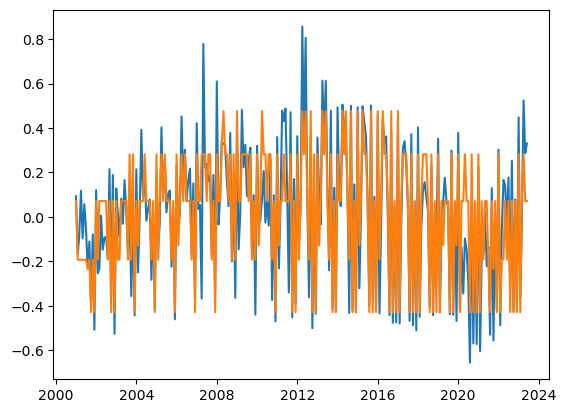

In [35]:
plt.plot(ObsvsPred)

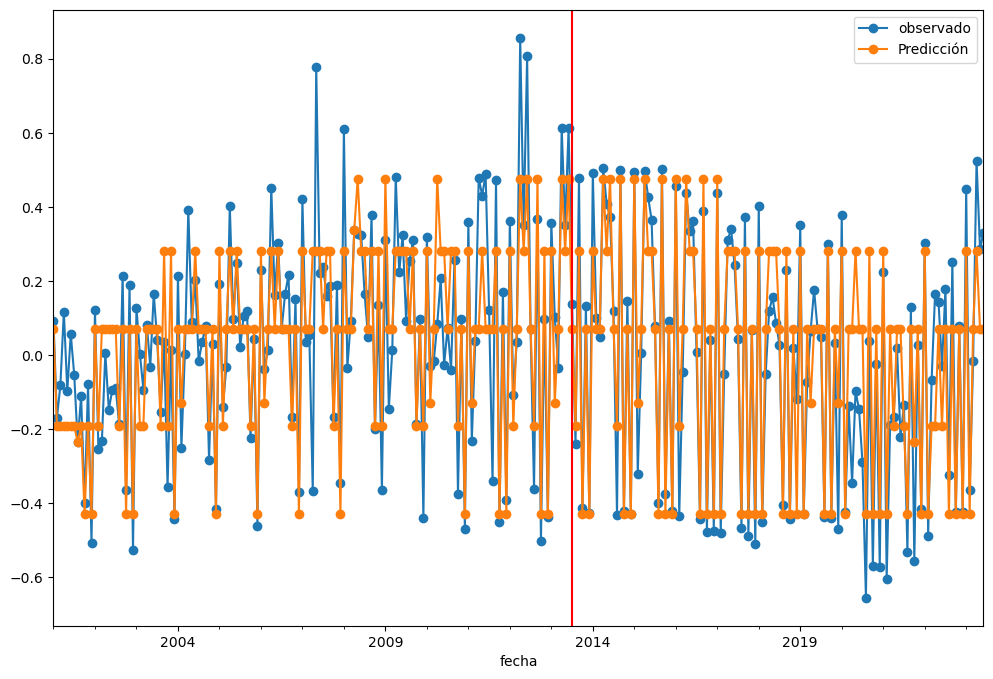

In [38]:
ax = ObsvsPred.plot( marker="o", figsize=(12,8))
ax.axvline(x=indicetrian_val_test[150].date(),color='red') ## Preguntat que hace este valor 876

## Sumando nuevamente la tendencia.

Teniendo en cuenta que anteriormente se eliminó la tendencia, es necesario volver a sumar dicha tendencia estimada a las predicciones obtenidas por el arbol de decisión esto se hace a continuacioón.


In [65]:
from scipy.special import boxcox, inv_boxcox

test_p_reg = trend[229:283] + test_prediction
test_target_reg = trend[229:283] + test_target

test_p_orig = inv_boxcox(test_p_reg, 0)
test_target_orig = inv_boxcox(test_target_reg, 0)

Resid_arb=test_p_orig - test_target_orig
print("ECM en el conjunto de prueba: ", np.sqrt(sum(Resid_arb**2)))

pred = np.concatenate((train_val_prediction, test_prediction))
pred_reg = trend[12:283] + pred
pred_orig = inv_boxcox(pred_reg, 0)

target = np.concatenate((train_val_target, test_target))
target_reg = trend[12:283] + target
target_orig = inv_boxcox(target_reg, 0)

Plot_predic = {'Original' : target_orig,'Prediccion' : pred_orig}
Todo=pd.DataFrame(data=Plot_predic, index=df1_dian.index)
print(Todo)

ECM en el conjunto de prueba:  17598963.51615658
                Original    Prediccion
fecha                                 
2001-01-01  1.893430e+06  1.853004e+06
2001-02-01  1.469073e+06  1.435506e+06
2001-03-01  1.617877e+06  1.447700e+06
2001-04-01  1.990345e+06  1.459997e+06
2001-05-01  1.620028e+06  1.472399e+06
...                  ...           ...
2023-02-01  1.128225e+07  1.057227e+07
2023-03-01  1.611574e+07  1.758087e+07
2023-04-01  2.789091e+07  2.188604e+07
2023-05-01  2.216499e+07  1.788082e+07
2023-06-01  2.337360e+07  1.803271e+07

[270 rows x 2 columns]


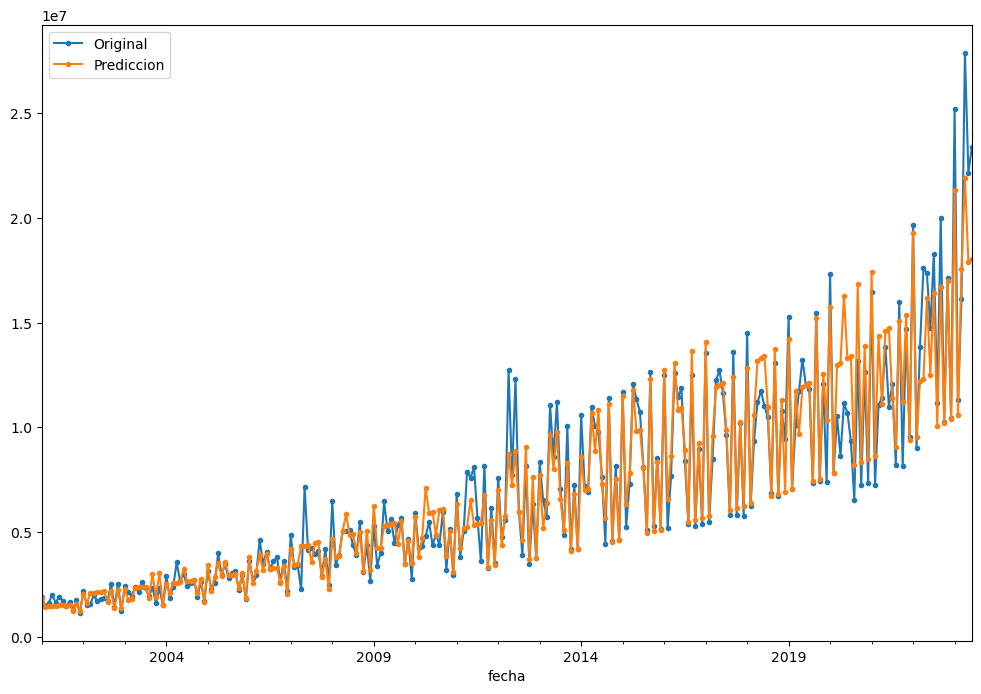

In [66]:
ax = Todo.plot( marker=".", figsize=(12,8))
#ax.axvline(x=dian_ts.index[129].date(),color='purple')
#ax.axvline(x=dian_ts.index[167].date(),color='purple')